In [1]:
# importing required libraries 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load datasets with datetime parsing
train_df = pd.read_csv("train.csv", parse_dates=["DateTime"])
test_df = pd.read_csv("test.csv", parse_dates=["DateTime"])

In [4]:
# Preview the datasets
print("Train Data:")
print(train_df.head())

print("\nTest Data:")
print(test_df.head())

# Check structure
print("\nTrain Info:")
train_df.info()

print("\nTest Info:")
test_df.info()


Train Data:
             DateTime  Junction  Vehicles           ID
0 2015-11-01 00:00:00         1        15  20151101001
1 2015-11-01 01:00:00         1        13  20151101011
2 2015-11-01 02:00:00         1        10  20151101021
3 2015-11-01 03:00:00         1         7  20151101031
4 2015-11-01 04:00:00         1         9  20151101041

Test Data:
             DateTime  Junction           ID
0 2017-07-01 00:00:00         1  20170701001
1 2017-07-01 01:00:00         1  20170701011
2 2017-07-01 02:00:00         1  20170701021
3 2017-07-01 03:00:00         1  20170701031
4 2017-07-01 04:00:00         1  20170701041

Train Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
 3   ID        48120 non-

In [5]:
# Null values
print("Missing values in training data:\n", train_df.isnull().sum())
print("Missing values in testing data:\n", test_df.isnull().sum())

# Duplicates
print("Duplicate rows in training data:", train_df.duplicated().sum())
print("Duplicate rows in testing data:", test_df.duplicated().sum())

Missing values in training data:
 DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64
Missing values in testing data:
 DateTime    0
Junction    0
ID          0
dtype: int64
Duplicate rows in training data: 0
Duplicate rows in testing data: 0


In [6]:
# Summary stats
print(train_df.describe())

                            DateTime      Junction      Vehicles            ID
count                          48120  48120.000000  48120.000000  4.812000e+04
mean   2016-09-19 06:03:56.109725696      2.180549     22.791334  2.016330e+10
min              2015-11-01 00:00:00      1.000000      1.000000  2.015110e+10
25%              2016-04-16 01:45:00      1.000000      9.000000  2.016042e+10
50%              2016-09-30 03:30:00      2.000000     15.000000  2.016093e+10
75%              2017-02-25 16:00:00      3.000000     29.000000  2.017023e+10
max              2017-06-30 23:00:00      4.000000    180.000000  2.017063e+10
std                              NaN      0.966955     20.750063  5.944854e+06


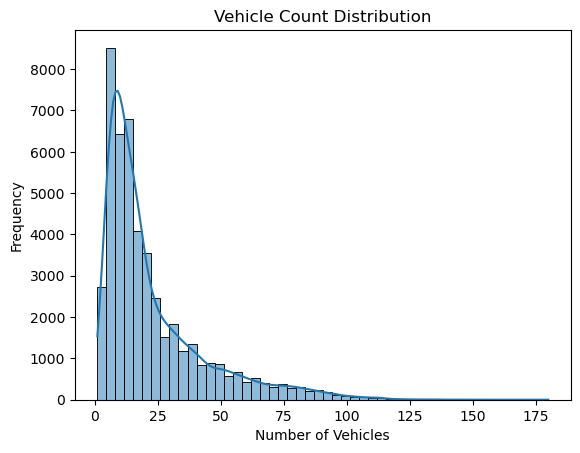

In [7]:
# Vehicle count distribution
sns.histplot(train_df['Vehicles'], bins=50, kde=True)
plt.title("Vehicle Count Distribution")
plt.xlabel("Number of Vehicles")
plt.ylabel("Frequency")
plt.show()

In [28]:
def add_time_features(df):
    df["hour"] = df["DateTime"].dt.hour
    df["day"] = df["DateTime"].dt.day
    df["month"] = df["DateTime"].dt.month
    df["weekday"] = df["DateTime"].dt.weekday  # 0 = Monday
    df["is_weekend"] = df["weekday"].isin([5, 6]).astype(int)
    return df

train_df = add_time_features(train_df)
test_df = add_time_features(test_df)


In [30]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
train_df["Junction"] = encoder.fit_transform(train_df["Junction"])
test_df["Junction"] = encoder.transform(test_df["Junction"])

In [32]:
# Feature columns (no VEHICLES in test set)
feature_cols = ["Junction", "hour", "day", "month", "weekday", "is_weekend"]

X_train = train_df[feature_cols]
y_train = train_df["Vehicles"]

X_test = test_df[feature_cols]

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

In [36]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [38]:
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_tr, y_tr)

RandomForestRegressor(max_depth=10, random_state=42)

In [40]:
# Predict on validation set
y_pred = model.predict(X_val)

# Calculate metrics
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print("Validation MAE:", mae)
print("Validation RMSE:", rmse)

Validation MAE: 6.8909494576787775
Validation RMSE: 10.072702557385071


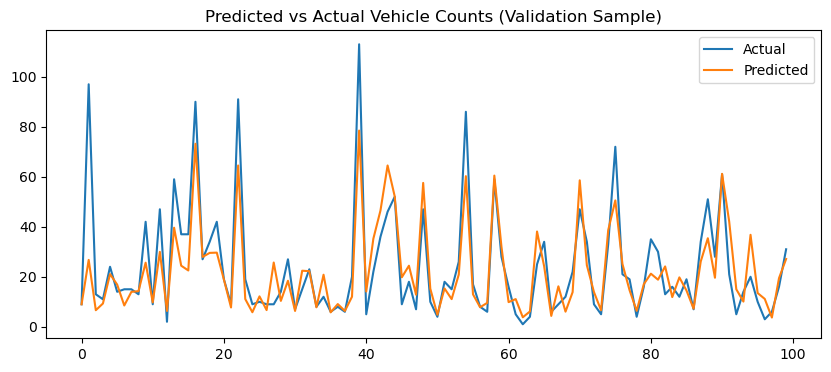

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(y_val.values[:100], label="Actual")
plt.plot(y_pred[:100], label="Predicted")
plt.legend()
plt.title("Predicted vs Actual Vehicle Counts (Validation Sample)")
plt.show()

In [44]:
test_df["Vehicles"] = model.predict(X_test)

In [46]:
submission = test_df[["ID", "Vehicles"]]
submission.to_csv("submission.csv", index=False)